# Usecase 2: Temperature prediction original model set-up

This notebook trains an ElasticNet model in Python with the same train-test splits as the ritme runs and a modelling set-up similar to the one described in [the original publication by Sunagawa et al. 2015](https://www.science.org/doi/10.1126/science.1261359).


This notebook can be run in the following conda environment:

```shell
mamba create -n ritme_model -c adamova -c qiime2 -c conda-forge -c bioconda -c pytorch -c anaconda ritme ipykernel -y
conda activate ritme_model
pip install -e .
```


Description of modelling set-up used by original publication:           
"Compositional data (see above) were normalized to ranks across samples and then used to learn a regression model to predict environmental measures. In particular, we fitted an elastic net model (44) using inner cross-validation to set the hyperparameters as implemented by the scikit-learn Python package"

For a proper comparison with ritme, we are running inner cross-validation on the train set and evaluating the resulting model on the test set.

## Setup

In [1]:
import pandas as pd
from sklearn.linear_model import ElasticNetCV

from src.eval_originals import get_metrics_n_scatterplot

%load_ext autoreload
%autoreload 2
%matplotlib inline

/cluster/work/bokulich/adamova/_conda_envs/ritme_model/lib/python3.10/site-packages/qiime2/core/archive/provenance.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
######## USER INPUTS ########

# path to folder where train-test splits used for ritme are stored
data_splits_folder = "data_splits_u2"

# path to processed feature table used by original publication
path_to_suna_ft = "../../data/u2_tara_ocean/otu_table_tara_ocean_proc.tsv"
path_to_suna_md = "../../data/u2_tara_ocean/md_tara_ocean.tsv"

######## END USER INPUTS #####

## Prepare data

In [3]:
# Get indices of training and test data used by ritme
ritme_train_df = pd.read_pickle(f"{data_splits_folder}/train_val.pkl")
ritme_test_df = pd.read_pickle(f"{data_splits_folder}/test.pkl")

train_idx = ritme_train_df.index.tolist()
test_idx = ritme_test_df.index.tolist()

In [4]:
# select these indices from sunagawa md + feature table
suna_ft = pd.read_csv(path_to_suna_ft, sep="\t", index_col=0)
predictor_cols = suna_ft.columns

suna_md = pd.read_csv(path_to_suna_md, sep="\t", index_col=0)

suna_data = suna_md.join(suna_ft, how="inner")

In [5]:
train_df = suna_data.loc[train_idx]
test_df = suna_data.loc[test_idx]

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

assert train_df.shape[0] == len(train_idx)
assert test_df.shape[0] == len(test_idx)

Train data shape: (111, 7256)
Test data shape: (28, 7256)


In [6]:
# Extract predictors and target
train_predictors = train_df[predictor_cols]
train_target = train_df["temperature_mean_degc"]

test_predictors = test_df[predictor_cols]
test_target = test_df["temperature_mean_degc"]

## Train & evaluate ElasticNet model in Python

In [7]:
# Train ElasticNet with inner 5-fold CV on ranked features
enet_cv = ElasticNetCV(
    l1_ratio=[0.1, 0.5, 0.9, 1.0],
    cv=5,
    random_state=123,
    n_jobs=-1,
)
enet_cv.fit(train_predictors, train_target)

/cluster/work/bokulich/adamova/_conda_envs/ritme_model/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.609e+00, tolerance: 6.679e-01
  model = cd_fast.enet_coordinate_descent(


,l1_ratio,"[0.1, 0.5, ...]"
,eps,0.001
,n_alphas,'deprecated'
,alphas,'warn'
,fit_intercept,True
,precompute,'auto'
,max_iter,1000
,tol,0.0001
,cv,5
,copy_X,True
,verbose,0


,rmse_train,r2_train,pearson_corr_train,pearson_corr_train_pvalue,rmse_test,r2_test,pearson_corr_test,pearson_corr_test_pvalue
original,0.108343,0.999805,0.999916,1.587999e-207,2.320768,0.887409,0.946861,2.534928e-14


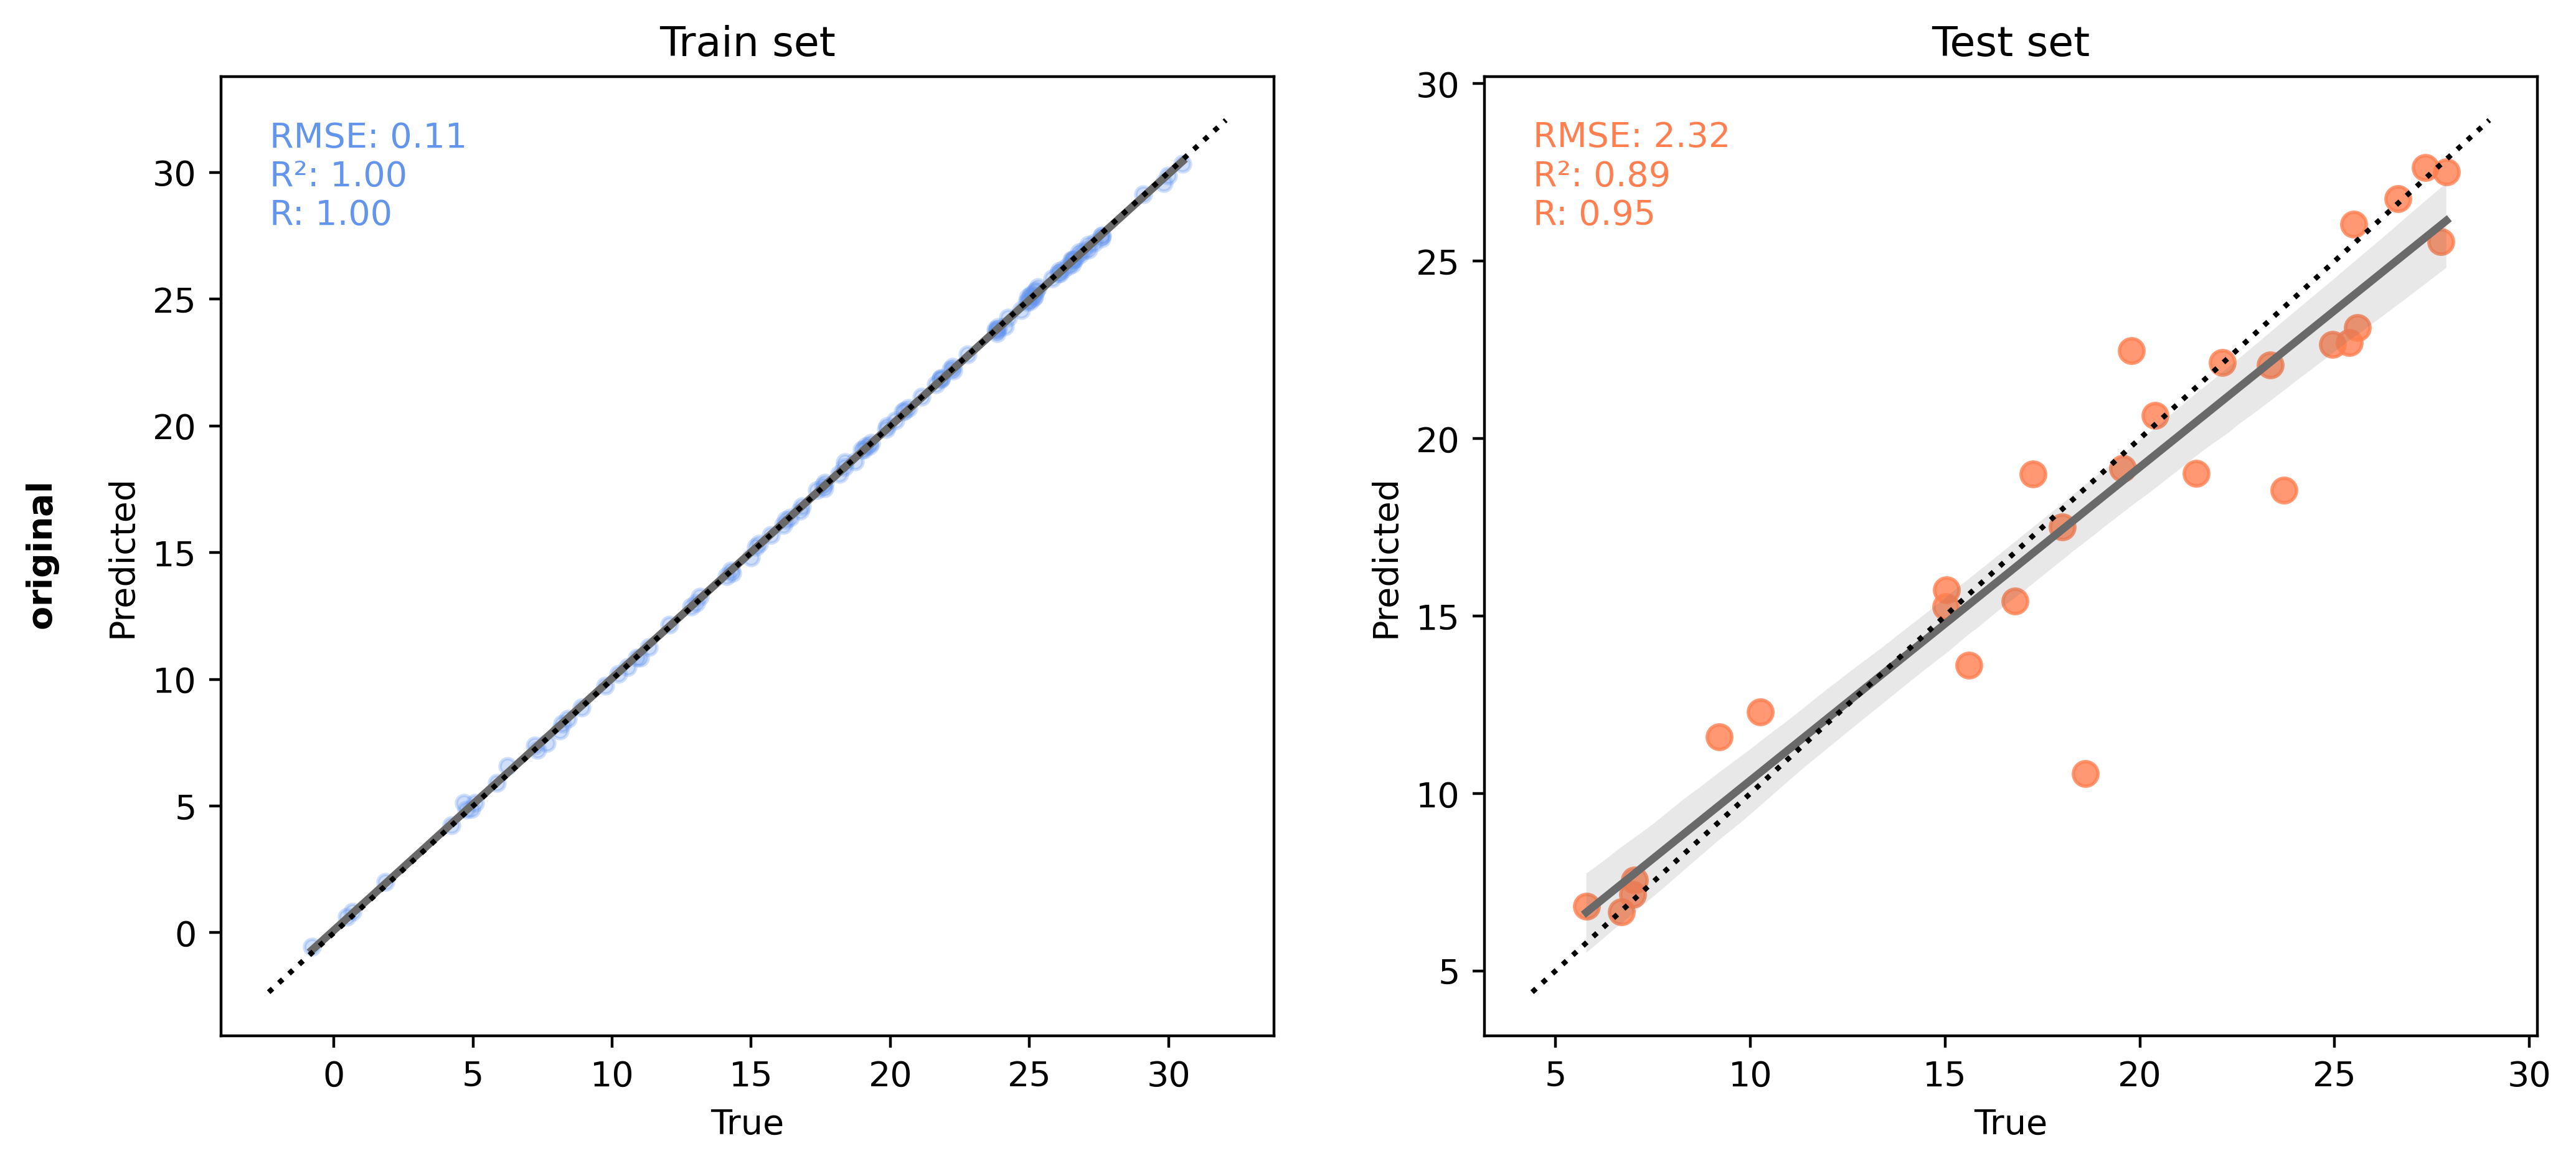

In [ ]:
# evaluate
metrics, fig = get_metrics_n_scatterplot(
    enet_cv, train_predictors, train_target, test_predictors, test_target
)
display(metrics)